# Notebook config

- Raw data: Kaggle+Tweet
    - 有做shuffle(打亂Tweet)

- 有EDA
- 限制 TF-IDF max_feature

In [1]:
# Data Analysis
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
sns.set_theme()

# Dimension reduction
from sklearn.decomposition import TruncatedSVD

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Text Processing 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Other
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

# NLTK resource
import nltk
# nltk.download('punkt')  # for word_tokenize
# nltk.download('wordnet')  # for WordNetLemmatizer
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [2]:
data = pd.read_csv('../data/kaggle+twitter.csv')
data.shape

(8772, 2)

## EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8772 entries, 0 to 8771
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8772 non-null   object
 1   flat    8772 non-null   object
dtypes: object(2)
memory usage: 137.2+ KB


In [4]:
data

,type,flat
0,INFJ,deal dr doorslam overreact one someon life dep...
1,ENTP,sound like typic trait role se h fe lack ethic...
2,INFP,coach biggest person nfl rex ryan think evil o...
3,INFP,haha wow interest sure yeah guess ok pixi time...
4,ENTP,know hate anyway rack disprin gon na play vide...
...,...,...
8767,INFJ,correct went troubl becom dish end irrespect d...
8768,ENFP,trick know valu know passion find group peopl ...
8769,INFP,ok talk friend age lot late go pose question f...
8770,INFP,even loner get lone feel like hard hard relati...


In [5]:
# Data distribution of 16 types
n_colors=16
color = px.colors.sample_colorscale('Purpor_r', [n/(n_colors -1) for n in range(n_colors)])
df_count = data['type'].value_counts()
df_count = df_count.rename_axis('type').reset_index(name='counts')
fig = px.bar(df_count, x='type', y='counts',
            color='type', color_discrete_sequence=color,
            # opacity=0.7,
            title='Type count (Kaggle+Twitter)',
            width=1000,
            height=600)
fig.show()

In [6]:
def WordCount(sentence: str):
    stripped = sentence.strip()  # str
    # print(type(stripped))
    splitted = stripped.split(' ')  # list
    # print(type(splitted))
    return len(splitted)

In [7]:
# Distribution of Lengths of all Posts
data_wordcount = data['flat'].apply(WordCount)
fig = px.histogram(data_wordcount, x='flat',
                title='Distribution of Lengths of all Posts',
                color_discrete_sequence=["lightsteelblue"],
                labels={"flat": "words"},
                width=1000, height=600)
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

### Word Cloud
Create Word Cloud of 16 types based on preprocessed tokens

In [8]:
# Tokens group by type
df_multi_word = data.groupby(['type'])['flat'].apply(lambda x: ' '.join(x)).reset_index()
df_multi_word

,type,flat
0,ENFJ,absolut care wrong firstx import find right ra...
1,ENFP,smoke year long enough know need quit lung eve...
2,ENTJ,woman lie note make feel anymor stand back bac...
3,ENTP,sound like typic trait role se h fe lack ethic...
4,ESFJ,pothead tri cocain coupl time mdma ecstasi spe...
5,ESFP,social descript fit better probabl descript ev...
6,ESTJ,stereotyp help sorri help realli well said rig...
7,ESTP,know cooler side pillow haha actual said exact...
8,INFJ,deal dr doorslam overreact one someon life dep...
9,INFP,coach biggest person nfl rex ryan think evil o...


In [9]:
def getSortFreqDictForText(sentence)->dict:
    # making dict for counting frequencies
    dict_freq = {}
    for word in sentence.split(" "):
        freq = dict_freq.get(word, 0)  # specify the default value
        dict_freq[word] = freq + 1
    # sort by frequency
    result = dict(sorted(dict_freq.items(), key=lambda item: item[1], reverse=True))
    return result

In [10]:
def createWordCloud(freq_dict: dict):
    '''
    Input: Frequency dictionary
    Outpue: Word cloud object
    Default max_words is 500.
    '''
    wc = WordCloud(background_color="white", colormap='tab20c',
                   max_words=500, width=600, height=400,
                   stopwords=None,
                   prefer_horizontal=1.0)
    return wc.generate_from_frequencies(freq_dict)

In [11]:
# Create dictionary with frequency
df_multi_word['freq_dict'] = df_multi_word['flat'].apply(getSortFreqDictForText)
df_multi_word

,type,flat,freq_dict
0,ENFJ,absolut care wrong firstx import find right ra...,"{'love': 2014, 'like': 2004, 'think': 1489, 'p..."
1,ENFP,smoke year long enough know need quit lung eve...,"{'like': 6940, 'think': 4838, 'peopl': 3886, '..."
2,ENTJ,woman lie note make feel anymor stand back bac...,"{'like': 2288, 'think': 1744, 'get': 1546, 'on..."
3,ENTP,sound like typic trait role se h fe lack ethic...,"{'like': 6749, 'think': 5031, 'one': 4454, 'ge..."
4,ESFJ,pothead tri cocain coupl time mdma ecstasi spe...,"{'love': 2223, 'amp': 1770, 'thank': 1726, 'ne..."
5,ESFP,social descript fit better probabl descript ev...,"{'amp': 3428, 'love': 2504, 'thank': 2365, 'ge..."
6,ESTJ,stereotyp help sorri help realli well said rig...,"{'new': 1182, 'today': 1081, 'see': 1025, 'get..."
7,ESTP,know cooler side pillow haha actual said exact...,"{'get': 1328, 'like': 1297, 'go': 1052, 'amp':..."
8,INFJ,deal dr doorslam overreact one someon life dep...,"{'like': 13268, 'think': 10409, 'peopl': 8507,..."
9,INFP,coach biggest person nfl rex ryan think evil o...,"{'like': 17518, 'think': 13279, 'feel': 10450,..."


In [12]:
multi_type_list = df_multi_word['type'].unique()

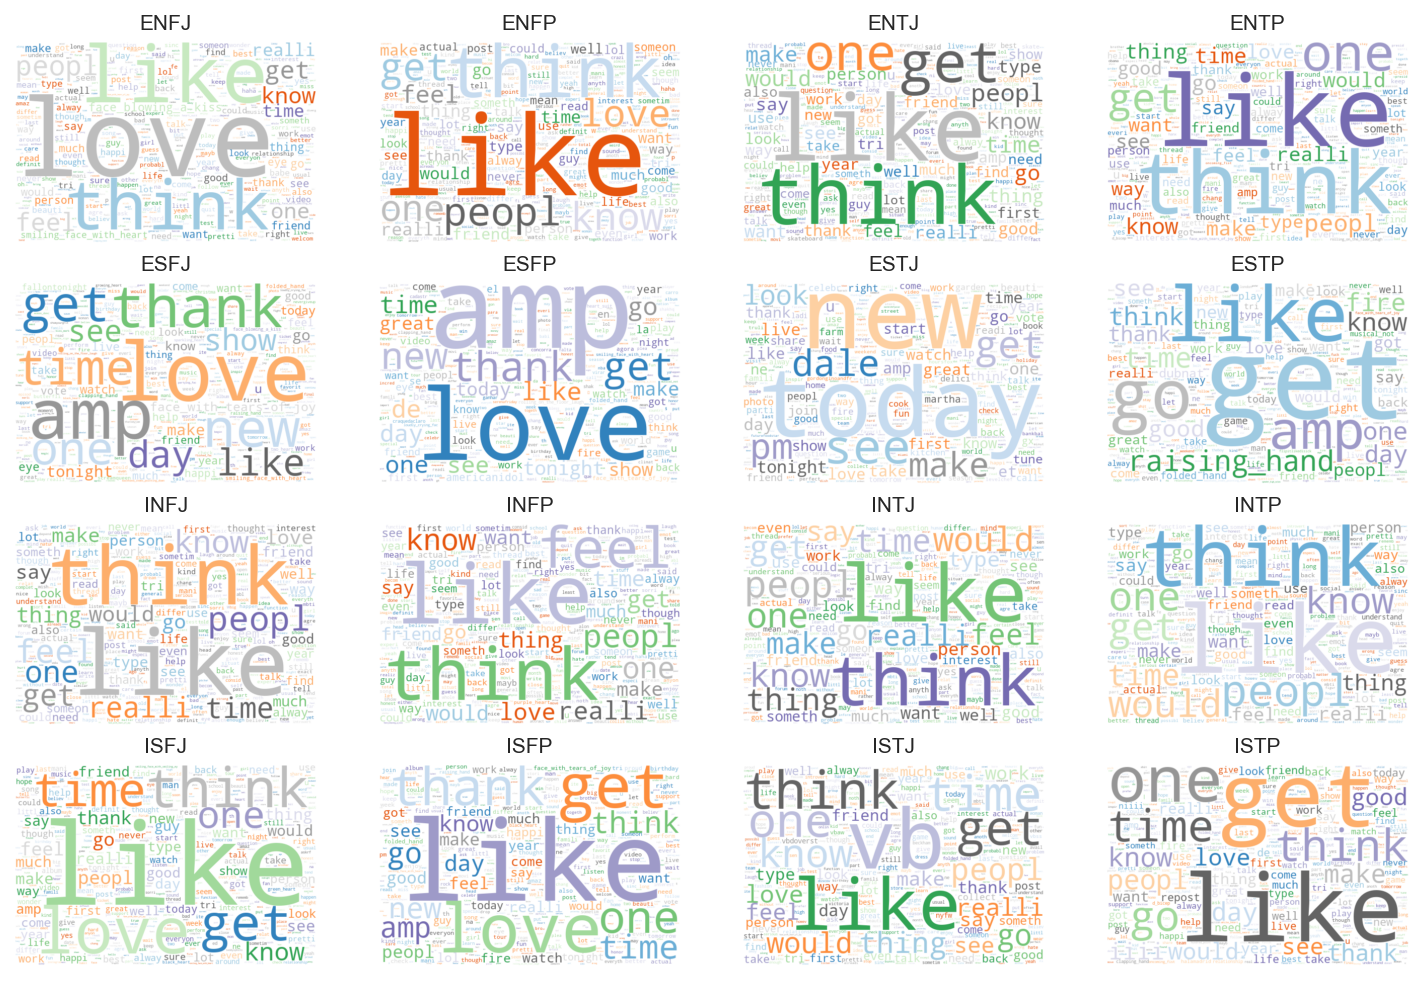

In [13]:
fig = plt.figure(figsize=(12,8), dpi=150)
for idx, mbti in enumerate(multi_type_list):
    ax = fig.add_subplot(4, 4, idx+1)
    freq_dict = getSortFreqDictForText(df_multi_word['flat'][idx])
    wordcloud = createWordCloud(freq_dict)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')
    ax.set_title(mbti, fontsize=10)
fig.show()
# fig.savefig('../img/wordcloud.png')

## Feature engineering

### TF-IDF

不設任何限制的 Tf-IDf 會有 78195 個 features

In [15]:
vectorizer = TfidfVectorizer(analyzer="word",
                          max_features=5000,
                          lowercase=None,
                          ngram_range=(1,1)).fit(data['flat'])
X_tfidf = vectorizer.transform(data['flat'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())
df_tfidf

,ab,abandon,abc,aben,abil,abl,abnorm,abort,abroad,absenc,...,yummi,yup,zac,zealand,zen,zero,zodiac,zombi,zone,zoom
0,0.0,0.0,0.0,0.0,0.000000,0.023161,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.023586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.04629,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.0,0.0,0.0,0.0,0.000000,0.023222,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
8768,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
8769,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
8770,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0


In [16]:
# top words in entire corpus
reverse_dic = {}
for key in vectorizer.vocabulary_:
    reverse_dic[vectorizer.vocabulary_[key]] = key
top_tfidf = np.asarray(np.argsort(np.sum(X_tfidf, axis=0))[0,-20:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_tfidf]

['like',
 'think',
 'peopl',
 'know',
 'one',
 'get',
 'feel',
 'realli',
 'would',
 'thing',
 'time',
 'type',
 'go',
 'love',
 'say',
 'make',
 'want',
 'person',
 'friend',
 'well']

### TruncatedSVD
計算出 100 個奇異值最大的值

In [17]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42).fit(X_tfidf)
X_svd = svd.transform(X_tfidf)
X_svd.shape

(8772, 100)

In [18]:
df_svd = pd.DataFrame(X_svd)
df_svd

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.561940,-0.028897,0.190150,-0.139254,0.097786,0.012552,0.036420,0.098107,-0.104731,-0.158202,...,-0.019014,0.014097,-0.008425,-0.013790,0.011261,0.027198,-0.029439,-0.018486,-0.012892,-0.048595
1,0.339056,0.089592,0.007780,-0.003127,-0.005652,-0.013994,0.054352,0.006041,0.010309,-0.059169,...,0.034307,-0.025705,0.040347,0.019400,0.065817,0.001895,0.123126,-0.013323,-0.041209,0.037928
2,0.469067,-0.038349,-0.066268,-0.020078,-0.046394,0.026983,0.018477,-0.077726,0.079365,0.024675,...,0.007333,-0.001699,-0.024683,0.020386,0.016480,0.014917,-0.031046,0.009546,0.035960,0.014488
3,0.375280,-0.026241,0.108852,-0.021977,0.142643,-0.066365,-0.025974,0.076087,-0.017264,-0.127363,...,-0.003902,-0.033900,-0.000307,-0.001272,-0.024661,-0.054984,0.006712,0.021216,0.032402,-0.047842
4,0.366280,-0.053353,0.015346,0.066154,-0.022211,-0.037269,-0.032593,0.017721,-0.020388,-0.000117,...,0.015535,0.022935,0.008683,0.034341,0.010217,-0.012965,0.017995,-0.008308,-0.011627,0.058013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.406399,-0.025567,0.046224,0.003140,-0.079388,0.017564,0.019175,-0.015665,0.020150,-0.016952,...,0.002076,0.024994,0.030158,0.000832,0.022035,0.006602,-0.001907,-0.000924,-0.021350,-0.017918
8768,0.462781,-0.017735,-0.044000,0.021158,-0.050861,-0.010833,0.107649,0.013288,-0.051402,-0.068414,...,-0.004058,-0.029205,-0.056780,-0.006127,-0.023713,0.023429,0.028743,-0.015101,-0.000235,0.019665
8769,0.536752,-0.115784,-0.018707,-0.077973,-0.028030,0.064473,-0.013656,-0.037774,-0.001224,0.027226,...,0.000494,-0.020552,0.021857,0.000887,0.008293,-0.008775,-0.017299,0.001777,0.006293,0.028384
8770,0.529239,-0.088614,0.022369,-0.021674,-0.050712,0.039615,-0.049221,-0.010733,-0.035705,-0.051929,...,0.019239,-0.039108,0.015117,0.003065,-0.032248,-0.015422,0.048138,-0.005772,-0.006894,-0.031048


## Binary Classification

In [19]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data_labeled = data.join(data.apply (lambda row: get_types (row),axis=1))
data_labeled

,type,flat,IE,NS,TF,JP
0,INFJ,deal dr doorslam overreact one someon life dep...,1,1,0,1
1,ENTP,sound like typic trait role se h fe lack ethic...,0,1,1,0
2,INFP,coach biggest person nfl rex ryan think evil o...,1,1,0,0
3,INFP,haha wow interest sure yeah guess ok pixi time...,1,1,0,0
4,ENTP,know hate anyway rack disprin gon na play vide...,0,1,1,0
...,...,...,...,...,...,...
8767,INFJ,correct went troubl becom dish end irrespect d...,1,1,0,1
8768,ENFP,trick know valu know passion find group peopl ...,0,1,0,0
8769,INFP,ok talk friend age lot late go pose question f...,1,1,0,0
8770,INFP,even loner get lone feel like hard hard relati...,1,1,0,0


In [20]:
# # Store data with labeled to csv
# data_labeled.to_csv('../data/Kaggle_twitter_labeled_1205.csv', index=False)

In [21]:
# # Load labeled data
# data_labeled = pd.read_csv('../data/Kaggle_MBTI_twitter_labeled_shuffle.csv')

In [22]:
# Plotting Classification class vs Frequency plot for IE, NS, TF, JP
I,N,T,J = data_labeled['IE'].value_counts()[0], data_labeled['NS'].value_counts()[0], data_labeled['TF'].value_counts()[0], data_labeled['JP'].value_counts()[0]
E,S,F,P = data_labeled['IE'].value_counts()[1], data_labeled['NS'].value_counts()[1], data_labeled['TF'].value_counts()[1], data_labeled['JP'].value_counts()[1]

dimensions = ['Introversion-Extraversion','Intuition-Sensing','Thinking-Feeling','Judging-Perceiving']
all = len(data_labeled)

fig = go.Figure()
fig.add_trace(go.Bar(name='I,N,T,J', x=dimensions, y=(I,N,T,J), customdata=[I/all,N/all,T/all,J/all], marker=dict(color=px.colors.qualitative.Pastel1[1])))
fig.add_trace(go.Bar(name='E,S,F,P', x=dimensions, y=(E,S,F,P), customdata=[E/all,S/all,F/all,P/all], marker=dict(color=px.colors.qualitative.Pastel1[3])))
fig.update_layout(barmode='group',title_text="Classification class vs Frequency plot", width=800)
fig.update_traces(hovertemplate='Actual: %{value}<br>Percent: %{customdata:,.2f}')
fig.show()

#### 相關係數
An assumption made in our model is that each letter type is independent of other types i.e. A person’s introversion/extroversion is not related to their judgement/perception. Nevertheless, we want to still test them below using a heat map

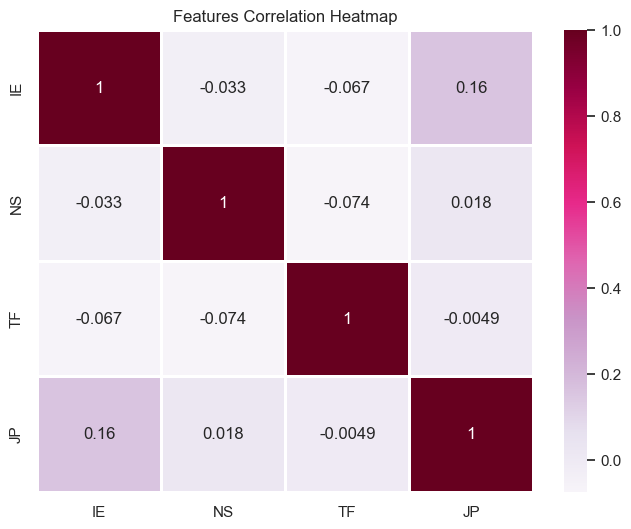

In [23]:
corr = data_labeled[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(8,6))
plt.title('Features Correlation Heatmap', size=12)
sns.heatmap(corr,cmap=plt.cm.PuRd,annot=True,linewidths=1)
plt.show()

#### Training and Testing Split

Only executive one time.

In [24]:
# Train test split
X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(X_svd, data_labeled['IE'], test_size=0.2, random_state=42, stratify=data_labeled['IE'])
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(X_svd, data_labeled['NS'], test_size=0.2, random_state=42, stratify=data_labeled['NS'])
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = train_test_split(X_svd, data_labeled['TF'], test_size=0.2, random_state=42, stratify=data_labeled['TF'])
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(X_svd, data_labeled['JP'], test_size=0.2, random_state=42, stratify=data_labeled['JP'])

In [25]:
IE_dataset = {"X_train": X_train_IE, "X_test": X_test_IE, "Y_train": Y_train_IE, "Y_test": Y_test_IE}
NS_dataset = {"X_train": X_train_NS, "X_test": X_test_NS, "Y_train": Y_train_NS, "Y_test": Y_test_NS}
TF_dataset = {"X_train": X_train_TF, "X_test": X_test_TF, "Y_train": Y_train_TF, "Y_test": Y_test_TF}
JP_dataset = {"X_train": X_train_JP, "X_test": X_test_JP, "Y_train": Y_train_JP, "Y_test": Y_test_JP}

In [26]:
# # Store binary dataset to pickle
# import pickle
# dataset = {'IE':IE_dataset,'NS':NS_dataset,'TF':TF_dataset,'JP':JP_dataset}

# for idx, (k,v) in enumerate(dataset.items()):
#     path = '../data/ka_tw_'+str(k)+'.pickle'
#     with open(path, 'wb') as file:
#         pickle.dump(v, file)

In [27]:
print(f'Each dataset:\nTrain|| X:{X_train_IE.shape}\tY:{Y_train_IE.shape} \nTest || X:{X_test_IE.shape}\tY:{Y_test_IE.shape}\n')

Each dataset:
Train|| X:(7017, 100)	Y:(7017,) 
Test || X:(1755, 100)	Y:(1755,)



#### Model method

In [28]:
def fitCV(model):
    '''
    Input: Base model
    Output: Models for each dimension
    '''
    # Cross validation
    grid1 = GridSearchCV(model,{},cv=10)
    grid2 = GridSearchCV(model,{},cv=10)
    grid3 = GridSearchCV(model,{},cv=10)
    grid4 = GridSearchCV(model,{},cv=10)
    # Fit
    model_IE = grid1.fit(X_train_IE,Y_train_IE)
    model_NS = grid2.fit(X_train_NS,Y_train_NS)
    model_TF = grid3.fit(X_train_TF,Y_train_TF)
    model_JP = grid4.fit(X_train_JP,Y_train_JP)

    return model_IE,model_NS,model_TF,model_JP

In [29]:
def predictCV(model_IE,model_NS,model_TF,model_JP):
    '''
    Input: 4 models
    Output: Predict on test data for each dimension
    '''
    ypredIE = model_IE.best_estimator_.predict(X_test_IE)
    ypredNS = model_NS.best_estimator_.predict(X_test_NS)
    ypredTF = model_TF.best_estimator_.predict(X_test_TF)
    ypredJP = model_JP.best_estimator_.predict(X_test_JP)
    return ypredIE, ypredNS, ypredTF, ypredJP

#### Evaluation method

In [30]:
def print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP):
   '''
   Function to print Classification Report of the given model
   This function takes 4 predicted output datasets as input.
   It computes classfication report: accuracy, recall, f1-score.
   It prints classification reports for all 4 predictions (models).
   '''
   print(f'Classification Report for Introversion(I) / Extroversion(E):\n {classification_report(Y_test_IE, ypredIE)}\n')
   print(f'Classification Report for Intuition(N) / Sensing(S):\n {classification_report(Y_test_NS, ypredNS)}\n')
   print(f'Classification Report for Thinking(T) / Feeling(F):\n{classification_report(Y_test_TF, ypredTF)}\n')
   print(f'Classification Report for Judging(J) / Perceiving(P):\n {classification_report(Y_test_JP, ypredJP)}\n')


def print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP):
   cm = confusion_matrix(Y_test_IE, ypredIE)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Reds_r',fmt='g')
   plt.ylabel('Y_test_IE')
   plt.xlabel('ypredIE')
   plt.title('Confusion matrix for Introversion(I) / Extroversion(E): ', size=12)

   cm = confusion_matrix(Y_test_NS, ypredNS)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Greens_r',fmt='g')
   plt.ylabel('Y_test_NS')
   plt.xlabel('ypredNS')
   plt.title('Confusion matrix for Intuition(N) / Sensing(S): ', size=12)

   cm = confusion_matrix(Y_test_TF, ypredTF)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Blues_r',fmt='g')
   plt.ylabel('Y_test_TF')
   plt.xlabel('ypredTF')
   plt.title('Confusion matrix for Thinking(T) / Feeling(F): ', size=12)

   cm = confusion_matrix(Y_test_JP, ypredJP)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Purples_r',fmt='g')
   plt.ylabel('Y_test_JP')
   plt.xlabel('ypredJP')
   plt.title('Confusion matrix for Judging(J) / Perceiving(P): ', size=12)


def print_roc_auc_curve(probIE, probNS, probTF, probJP, title:str):
   fp_IE, tp_IE, _ = roc_curve(Y_test_IE, probIE[:,1])
   fp_NS, tp_NS, _ = roc_curve(Y_test_NS, probNS[:,1])
   fp_TF, tp_TF, _ = roc_curve(Y_test_TF, probTF[:,1])
   fp_JP, tp_JP, _ = roc_curve(Y_test_JP, probJP[:,1])
   plt.figure(figsize=(8,5))
   plt.plot(fp_IE, tp_IE, linestyle=':', color='indianred', label=f'Introversion(I) / Extroversion(E) (area={auc(fp_IE, tp_IE):.2f})',linewidth=1.8)
   plt.plot(fp_NS, tp_NS, linestyle='--', color='darkseagreen', label=f'Intuition(N) / Sensing(S) (area={auc(fp_NS, tp_NS):.2f})',linewidth=1.8)
   plt.plot(fp_TF, tp_TF, linestyle='-.', color='dodgerblue', label=f'Thinking(T) / Feeling(F) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.plot(fp_JP, tp_JP, linestyle='--', color='orchid', label=f'Judging(J) / Perceiving(P) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title(title+' ROC Curve')
   plt.legend(loc='best')
   # plt.savefig('../img/ROC_tw_'+title+'.png')

### Training

#### Naive Bayes Model

In [31]:
gNB = GaussianNB()
# Fit
gNB_IE, gNB_NS, gNB_TF, gNB_JP = fitCV(gNB)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(gNB_IE,gNB_NS,gNB_TF,gNB_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.40      0.22      0.29       411
           1       0.79      0.90      0.84      1344

    accuracy                           0.74      1755
   macro avg       0.59      0.56      0.56      1755
weighted avg       0.70      0.74      0.71      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.39      0.25      0.30       253
           1       0.88      0.94      0.91      1502

    accuracy                           0.84      1755
   macro avg       0.64      0.59      0.60      1755
weighted avg       0.81      0.84      0.82      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       951
           1       0.67      0.74      0.70       804

    accuracy

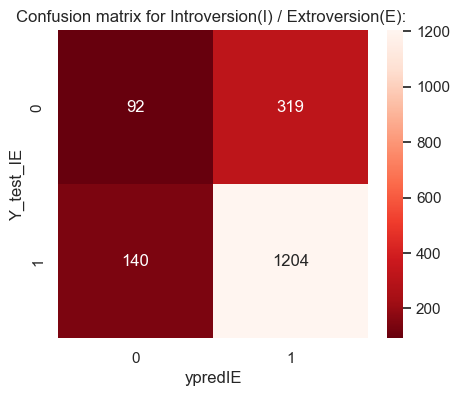

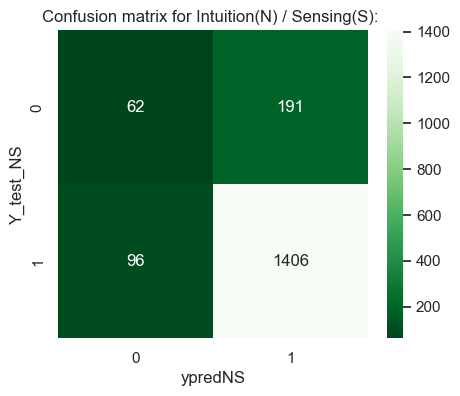

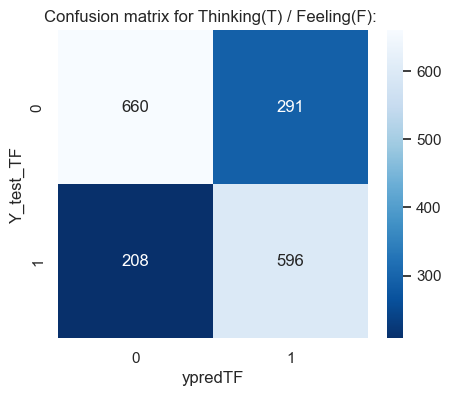

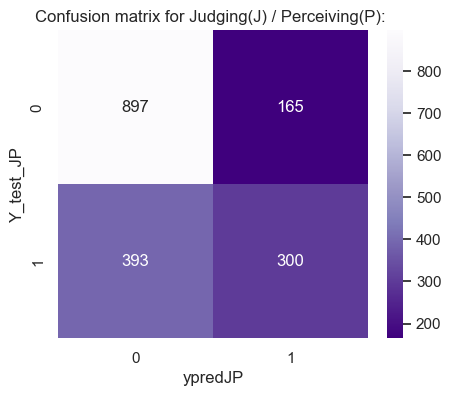

In [32]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

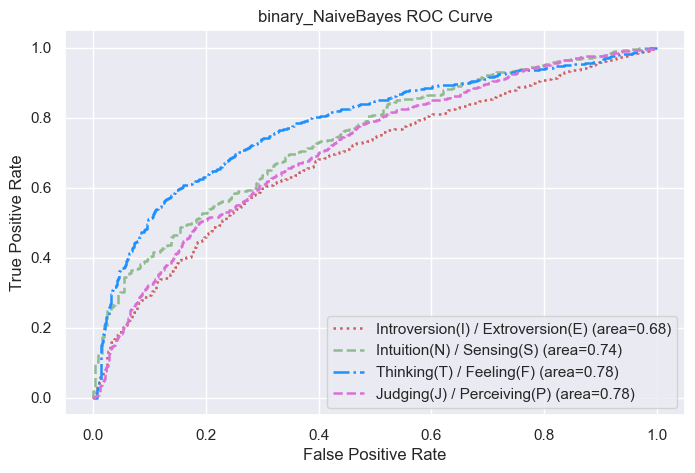

In [33]:
# ROC curve
print_roc_auc_curve(gNB_IE.best_estimator_.predict_proba(X_test_IE),
                    gNB_NS.best_estimator_.predict_proba(X_test_NS),
                    gNB_TF.best_estimator_.predict_proba(X_test_TF),
                    gNB_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_NaiveBayes')

#### Logistic Regression

In [34]:
log = LogisticRegression(random_state=42,max_iter=500)
# Fit
log_IE, log_NS, log_TF, log_JP = fitCV(log)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(log_IE,log_NS,log_TF,log_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.65      0.11      0.18       411
           1       0.78      0.98      0.87      1344

    accuracy                           0.78      1755
   macro avg       0.71      0.54      0.53      1755
weighted avg       0.75      0.78      0.71      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.69      0.04      0.07       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.78      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       951
           1       0.78      0.76      0.77       804

    accuracy

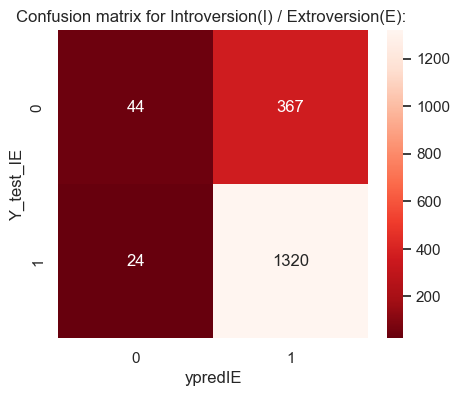

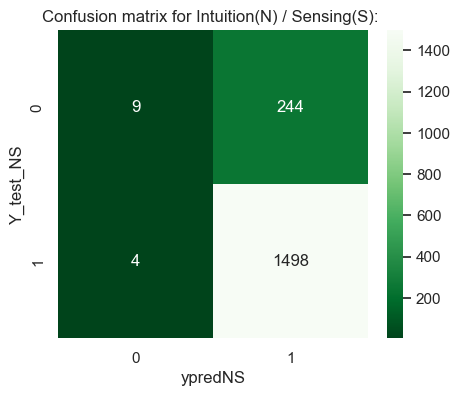

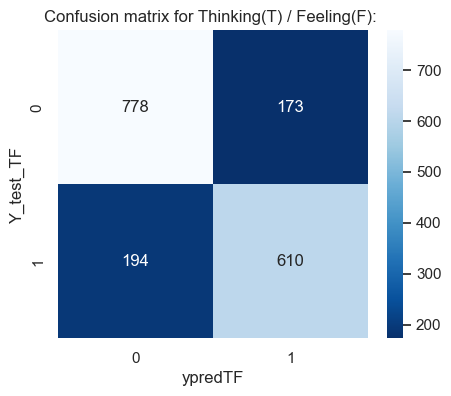

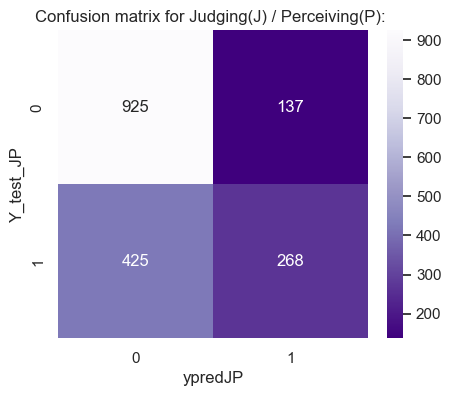

In [35]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

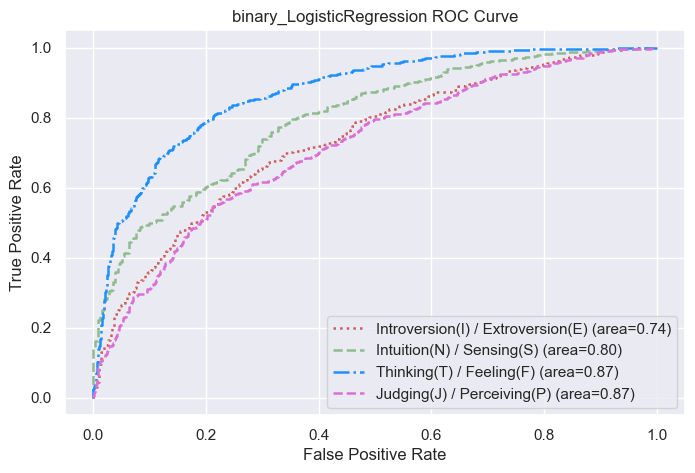

In [36]:
# ROC curve
print_roc_auc_curve(log_IE.best_estimator_.predict_proba(X_test_IE),
                    log_NS.best_estimator_.predict_proba(X_test_NS),
                    log_TF.best_estimator_.predict_proba(X_test_TF),
                    log_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_LogisticRegression')

#### SVM

In [37]:
svm = SVC(random_state=42, probability=True)
# Fit
svm_IE, svm_NS, svm_TF, svm_JP = fitCV(svm)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(svm_IE,svm_NS,svm_TF,svm_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.52      0.03      0.05       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.65      0.51      0.46      1755
weighted avg       0.71      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.71      0.04      0.07       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.79      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       951
           1       0.78      0.75      0.77       804

    accuracy

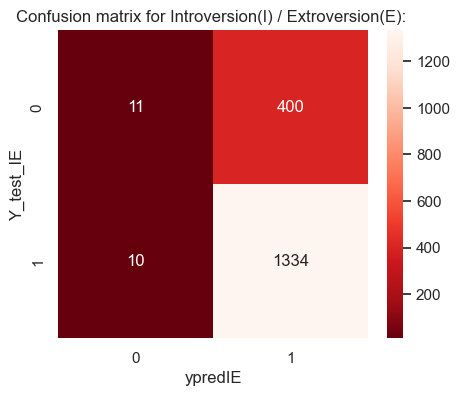

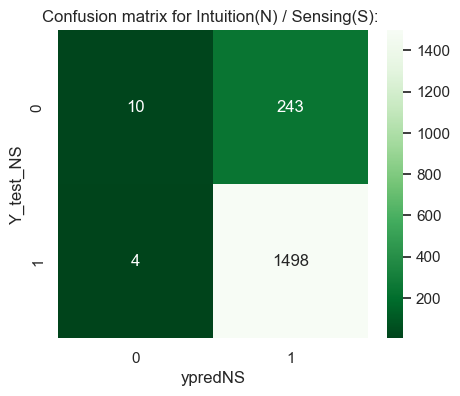

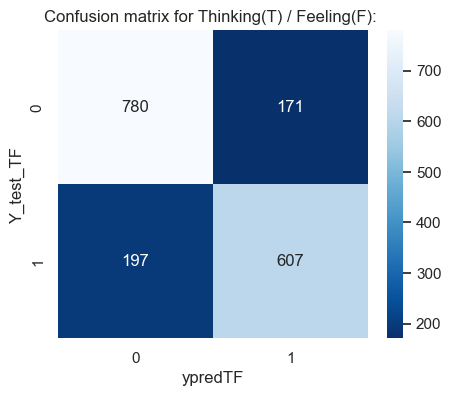

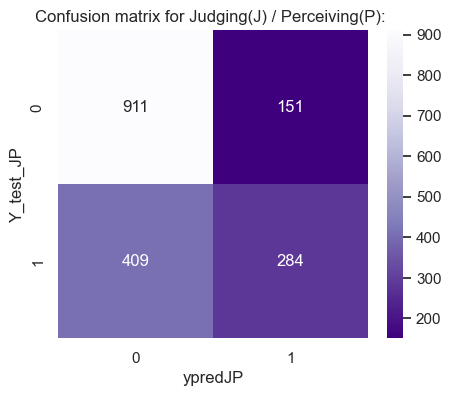

In [38]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

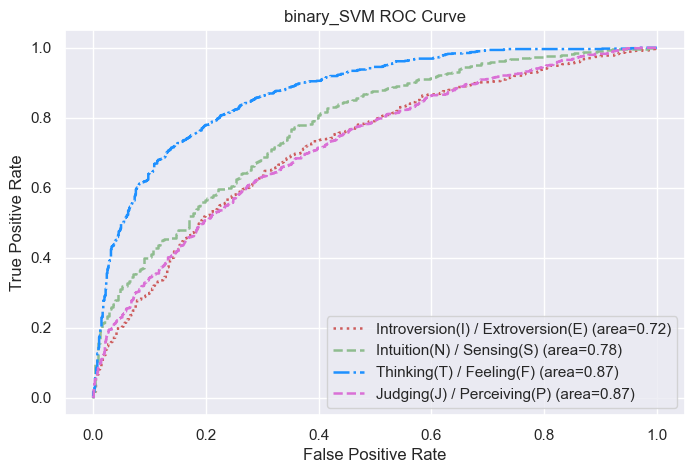

In [39]:
# ROC curve
print_roc_auc_curve(svm_IE.best_estimator_.predict_proba(X_test_IE),
                    svm_NS.best_estimator_.predict_proba(X_test_NS),
                    svm_TF.best_estimator_.predict_proba(X_test_TF),
                    svm_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_SVM')

#### K-Nearest Neighbor (KNN)

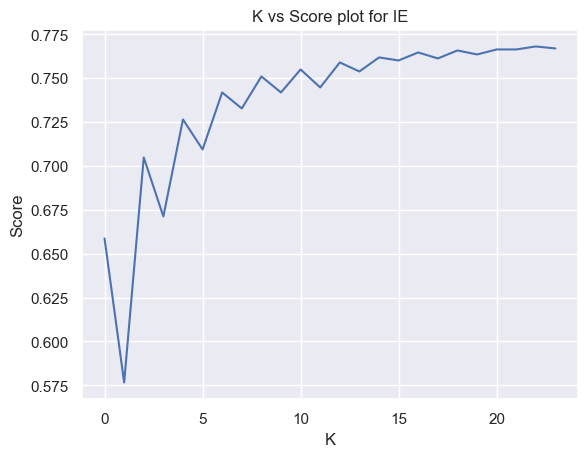

Maximum Accuracy of 0.7680911680911681 at k=23


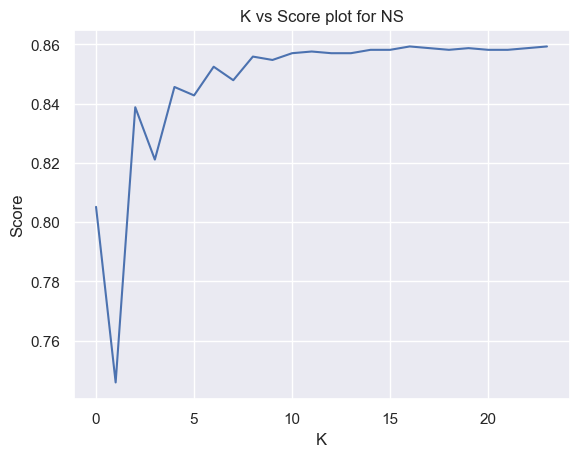

Maximum Accuracy of 0.8592592592592593 at k=17


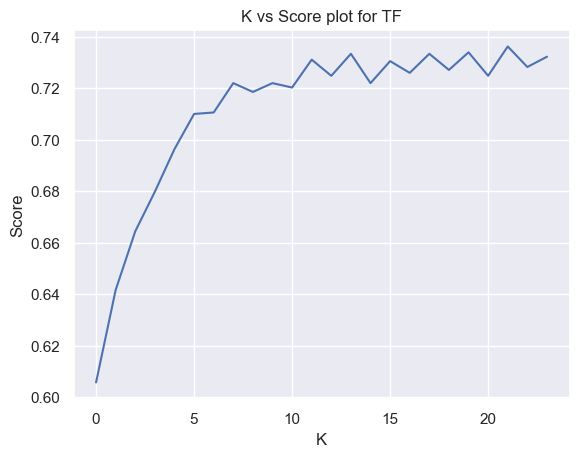

Maximum Accuracy of 0.7361823361823362 at k=22


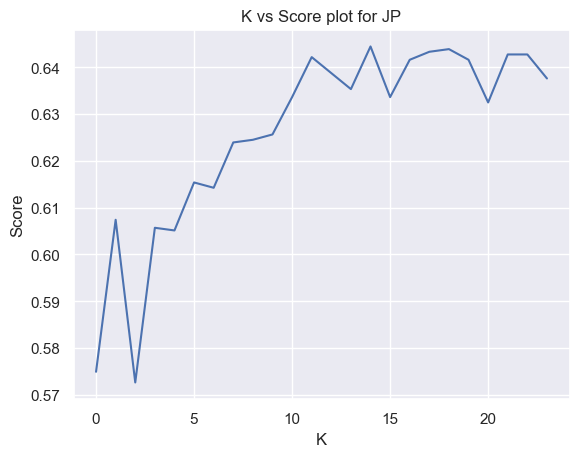

Maximum Accuracy of 0.7361823361823362 at k=22


In [40]:
def plot_graph(val,xlab,ylab,title):
    plt.figure()
    plt.plot(val)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,25):
    k1 = KNeighborsClassifier(n_neighbors=i)
    k1.fit(X_train_IE, Y_train_IE)
    k1_score.append(k1.score(X_test_IE, Y_test_IE))

df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'K','Score','K vs Score plot for IE')
print(f'Maximum Accuracy of {df1.max()[0]} at k={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,25):
	k2 = KNeighborsClassifier(n_neighbors=i)
	k2.fit(X_train_NS, Y_train_NS)
	k2_score.append(k2.score(X_test_NS, Y_test_NS))

df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'K','Score','K vs Score plot for NS')
print(f'Maximum Accuracy of {df2.max()[0]} at k={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,25):
  k3 = KNeighborsClassifier(n_neighbors=i)
  k3.fit(X_train_TF, Y_train_TF)
  k3_score.append(k3.score(X_test_TF, Y_test_TF))

df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'K','Score','K vs Score plot for TF')
print(f'Maximum Accuracy of {df3.max()[0]} at k={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,25):
  k4 = KNeighborsClassifier(n_neighbors=i)
  k4.fit(X_train_JP, Y_train_JP)
  k4_score.append(k4.score(X_test_JP, Y_test_JP))

df4 = pd.DataFrame(k3_score,columns=['JP'])
plot_graph(k4_score,'K','Score','K vs Score plot for JP')
print(f'Maximum Accuracy of {df4.max()[0]} at k={df4.idxmax()[0]+1}')

In [41]:
kbestIE = KNeighborsClassifier(n_neighbors=df1.idxmax()[0]+1)
knn_IE = kbestIE.fit(X_train_IE,Y_train_IE)
ypredIE = knn_IE.predict(X_test_IE)

kbestNS = KNeighborsClassifier(n_neighbors=df2.idxmax()[0]+1)
knn_NS = kbestNS.fit(X_train_NS,Y_train_NS)
ypredNS = knn_NS.predict(X_test_NS)

kbestTF = KNeighborsClassifier(n_neighbors=df3.idxmax()[0]+1)
knn_TF = kbestTF.fit(X_train_TF,Y_train_TF)
ypredTF = knn_TF.predict(X_test_TF)

kbestJP = KNeighborsClassifier(n_neighbors=df4.idxmax()[0]+1)
knn_JP = kbestJP.fit(X_train_JP,Y_train_JP)
ypredJP = knn_JP.predict(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.57      0.04      0.08       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.67      0.52      0.47      1755
weighted avg       0.72      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.64      0.06      0.10       253
           1       0.86      0.99      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.75      0.53      0.51      1755
weighted avg       0.83      0.86      0.81      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       951
           1       0.70      0.75      0.72       804

    accuracy

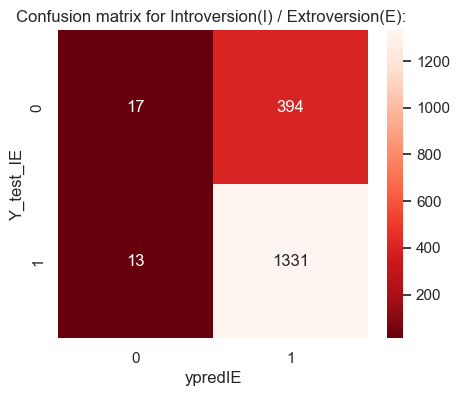

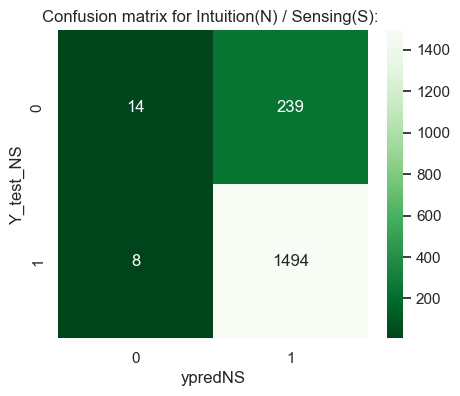

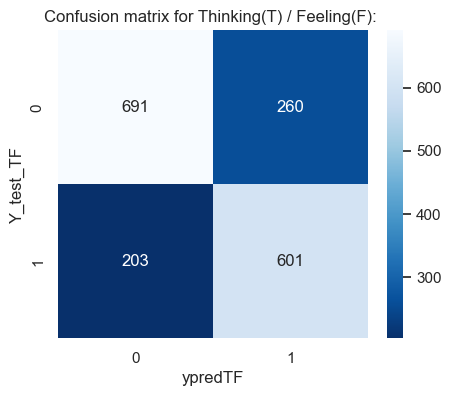

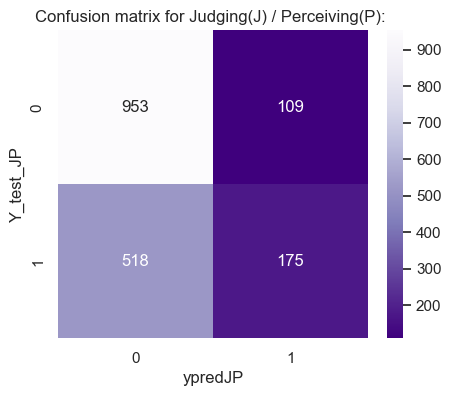

In [42]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

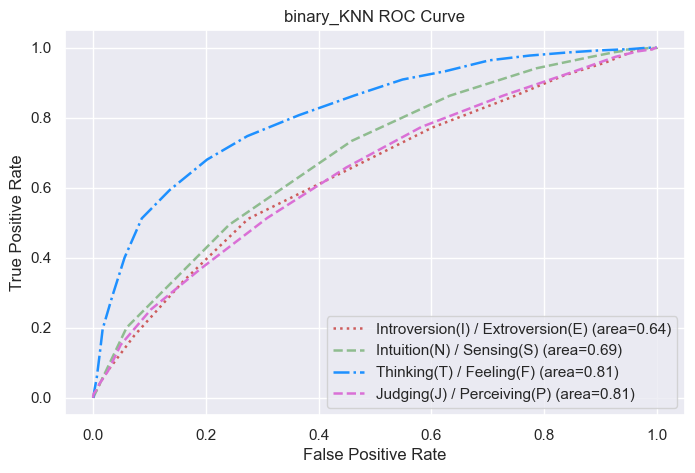

In [43]:
# ROC curve
print_roc_auc_curve(kbestIE.predict_proba(X_test_IE),
                    kbestNS.predict_proba(X_test_NS),
                    kbestTF.predict_proba(X_test_TF),
                    kbestJP.predict_proba(X_test_JP),
                    title='binary_KNN')

#### Decision Tree

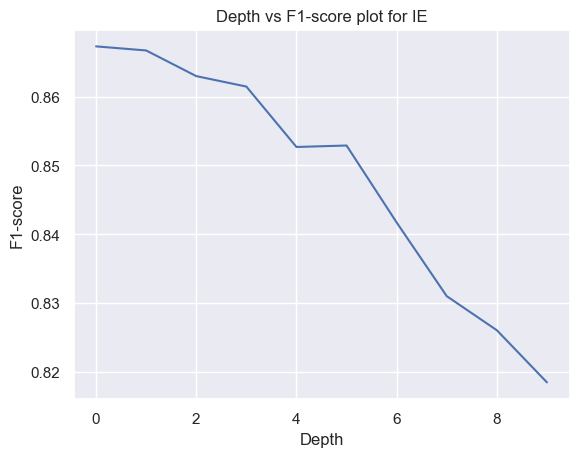

Maximum F1-score of 0.8673122969336372 at depth=1


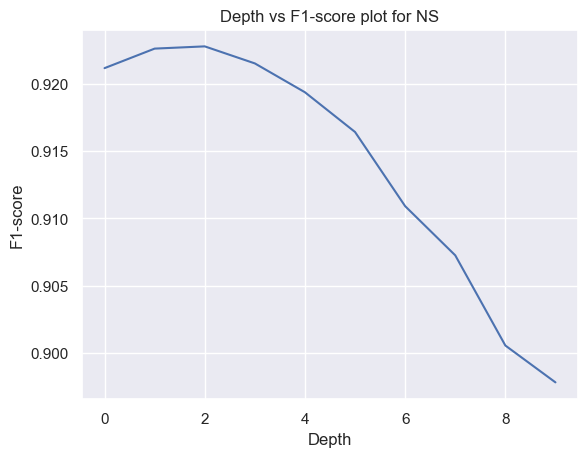

Maximum F1-score of 0.9227571566155002 at depth=3


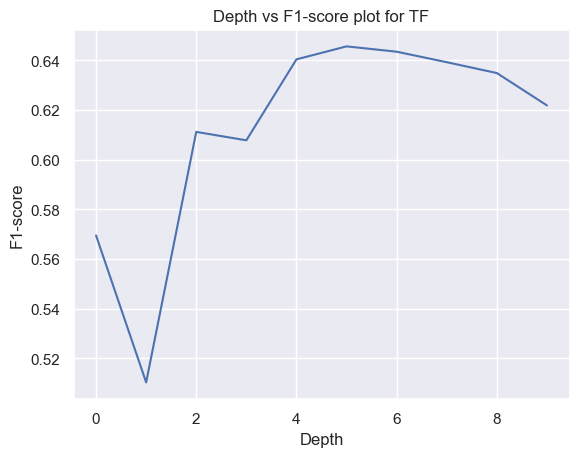

Maximum F1-score of 0.6456490545552466 at depth=6


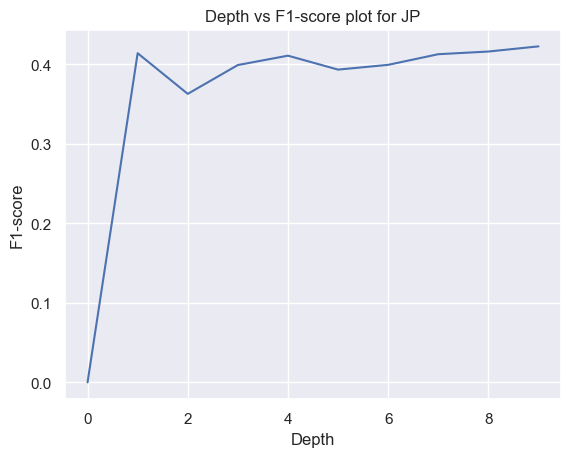

Maximum F1-score of 0.42261435170990236 at depth=10


In [44]:
def plot_graph(val, title):
    plt.plot(val)
    plt.ylabel('F1-score')
    plt.xlabel('Depth')
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,11):
    k1_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k1_cart, X_train_IE, Y_train_IE, cv=10, scoring='f1')
    k1_score.append(score.mean())
df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'Depth vs F1-score plot for IE')
print(f'Maximum F1-score of {df1.max()[0]} at depth={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,11):
    k2_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k2_cart, X_train_NS, Y_train_NS, cv=10, scoring='f1')
    k2_score.append(score.mean())
df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'Depth vs F1-score plot for NS')
print(f'Maximum F1-score of {df2.max()[0]} at depth={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,11):
    k3_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k3_cart, X_train_TF, Y_train_TF, cv=10, scoring='f1')
    k3_score.append(score.mean())
df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'Depth vs F1-score plot for TF')
print(f'Maximum F1-score of {df3.max()[0]} at depth={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,11):
    k4_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k4_cart, X_train_JP, Y_train_JP, cv=10, scoring='f1')
    k4_score.append(score.mean())
df4 = pd.DataFrame(k4_score,columns=['JP'])
plot_graph(k4_score,'Depth vs F1-score plot for JP')
print(f'Maximum F1-score of {df4.max()[0]} at depth={df4.idxmax()[0]+1}')

In [45]:
dtbestIE = DecisionTreeClassifier(criterion="gini", max_depth=df1.idxmax()[0]+1, random_state=42)
dt_IE = dtbestIE.fit(X_train_IE,Y_train_IE)
ypredIE = dt_IE.predict(X_test_IE)

dtbestNS = DecisionTreeClassifier(criterion="gini", max_depth=df2.idxmax()[0]+1, random_state=42)
dt_NS = dtbestNS.fit(X_train_NS,Y_train_NS)
ypredNS = dt_NS.predict(X_test_NS)

dtbestTF = DecisionTreeClassifier(criterion="gini", max_depth=df3.idxmax()[0]+1, random_state=42)
dt_TF = dtbestTF.fit(X_train_TF,Y_train_TF)
ypredTF = dt_TF.predict(X_test_TF)

dtbestJP = DecisionTreeClassifier(criterion="gini", max_depth=df4.idxmax()[0]+1, random_state=42)
dt_JP = dtbestJP.fit(X_train_JP,Y_train_JP)
ypredJP = dt_JP.predict(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.77      1.00      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.38      0.50      0.43      1755
weighted avg       0.59      0.77      0.66      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.77      0.04      0.08       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.81      0.52      0.50      1755
weighted avg       0.85      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       951
           1       0.69      0.58      0.63       804

    accuracy

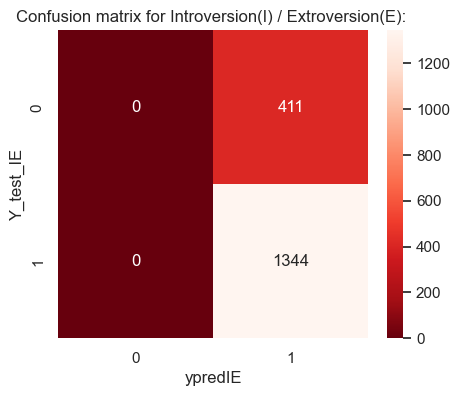

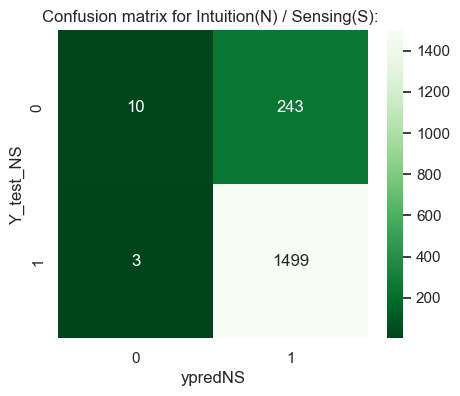

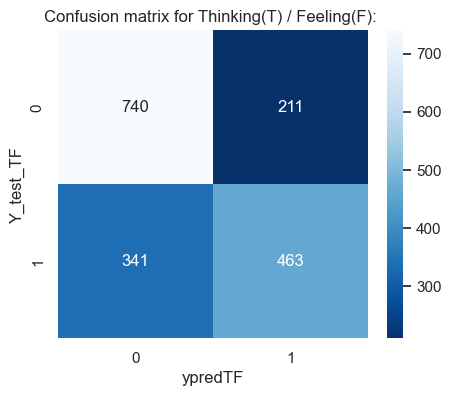

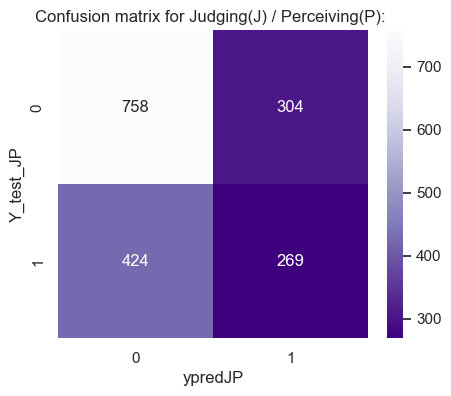

In [46]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

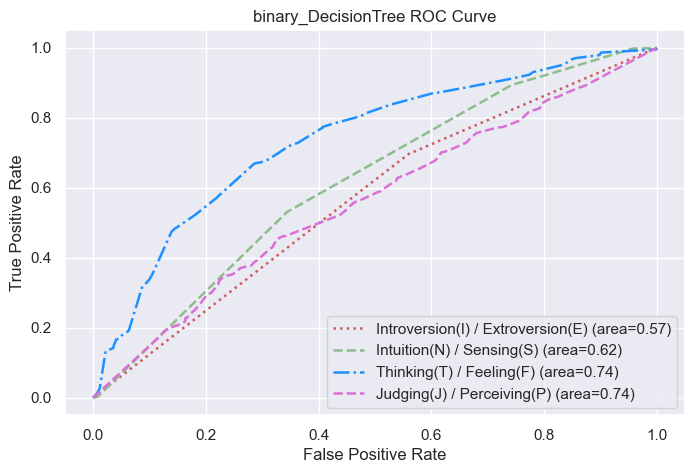

In [47]:
# ROC curve
print_roc_auc_curve(dtbestIE.predict_proba(X_test_IE),
                    dtbestNS.predict_proba(X_test_NS),
                    dtbestTF.predict_proba(X_test_TF),
                    dtbestJP.predict_proba(X_test_JP),
                    title='binary_DecisionTree')

#### Random Forest

In [48]:
rf = RandomForestClassifier(n_estimators=200,  # after tuning
                            random_state=42)
# Fit
rf_IE, rf_NS, rf_TF, rf_JP = fitCV(rf)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(rf_IE,rf_NS,rf_TF,rf_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.44      0.02      0.04       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.76      1755
   macro avg       0.61      0.51      0.45      1755
weighted avg       0.69      0.76      0.67      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.69      0.04      0.07       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.78      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       951
           1       0.77      0.67      0.72       804

    accuracy

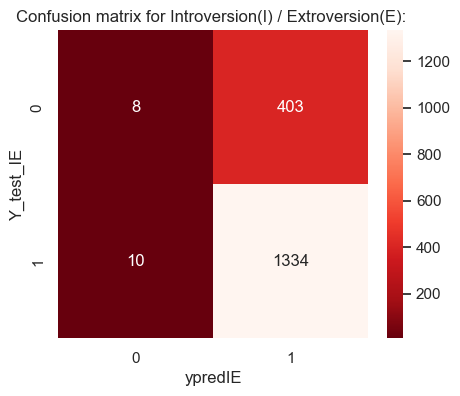

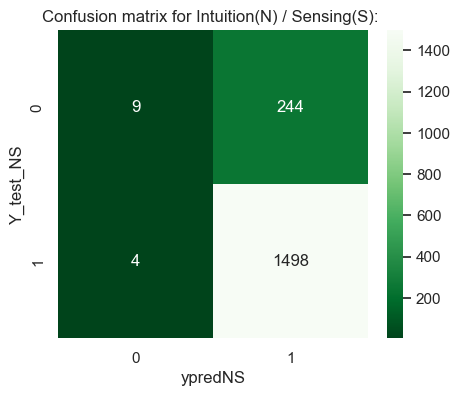

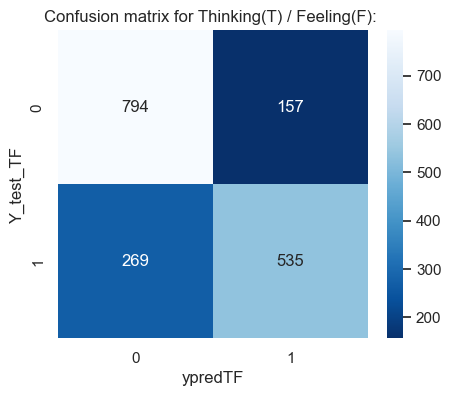

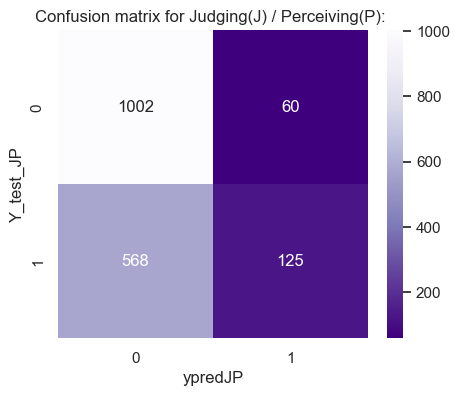

In [49]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

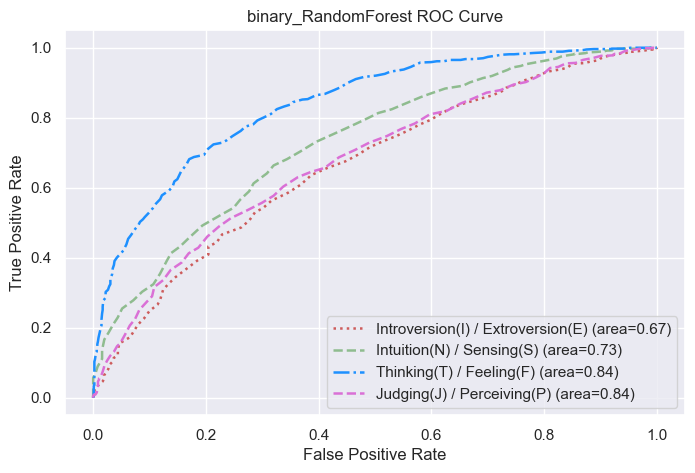

In [50]:
# ROC curve
print_roc_auc_curve(rf_IE.best_estimator_.predict_proba(X_test_IE),
                    rf_NS.best_estimator_.predict_proba(X_test_NS),
                    rf_TF.best_estimator_.predict_proba(X_test_TF),
                    rf_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_RandomForest')

#### Gradient Boost

In [51]:
gb = GradientBoostingClassifier(random_state=42)
# Fit
gb_IE, gb_NS, gb_TF, gb_JP = fitCV(gb)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(gb_IE,gb_NS,gb_TF,gb_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.65      0.11      0.18       411
           1       0.78      0.98      0.87      1344

    accuracy                           0.78      1755
   macro avg       0.71      0.54      0.53      1755
weighted avg       0.75      0.78      0.71      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.50      0.06      0.10       253
           1       0.86      0.99      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.68      0.52      0.51      1755
weighted avg       0.81      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       951
           1       0.76      0.71      0.73       804

    accuracy

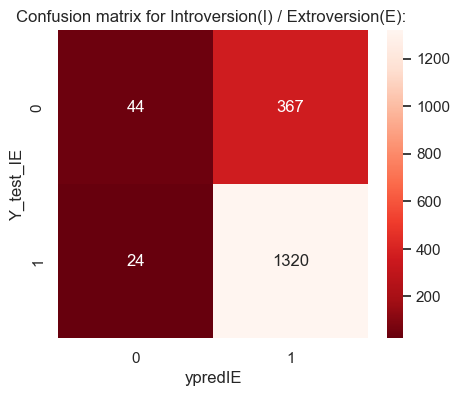

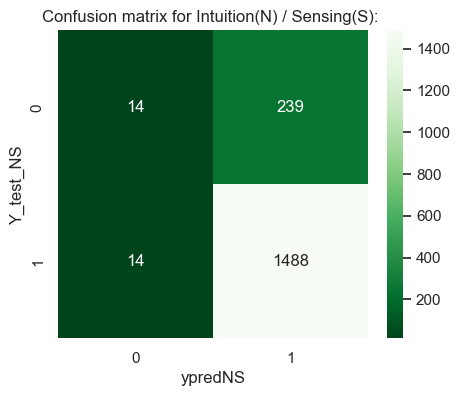

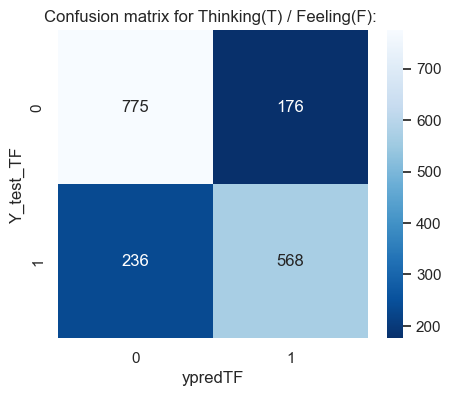

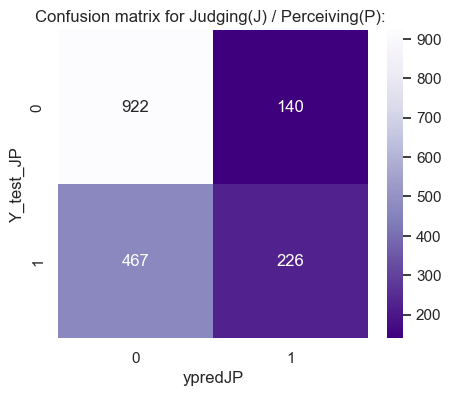

In [52]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

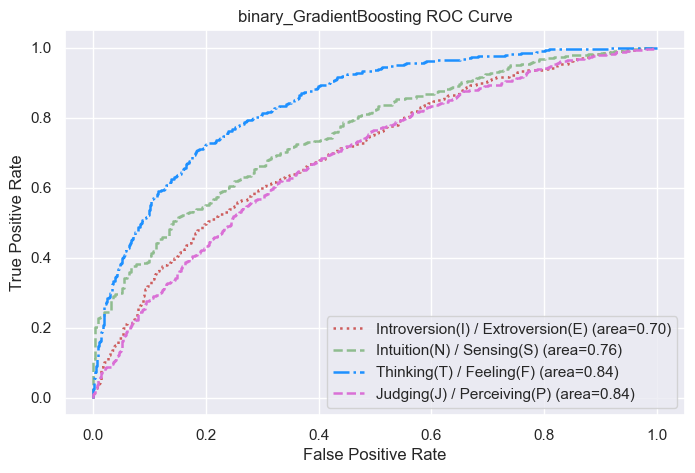

In [53]:
# ROC curve
print_roc_auc_curve(gb_IE.best_estimator_.predict_proba(X_test_IE),
                    gb_NS.best_estimator_.predict_proba(X_test_NS),
                    gb_TF.best_estimator_.predict_proba(X_test_TF),
                    gb_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_GradientBoosting')

## Test on Celebrity dataset
利用名人 Twitter 資料集來預測陌生資料的 MBTI

### Preprocess

In [54]:
# # If you didn't install emoji before:
# !pip install emoji --upgrade
import emoji

In [60]:
def combineRow(data):
	tweet_data = []  
	tmp = data.copy()
	m = tmp['tweet'].str.contains('\w+')
	tmp_ = tmp[m].groupby((~m).cumsum(), as_index=False).agg(', '.join)
	tweet_data.append(tmp_)
	tweet_data = pd.concat(tweet_data)
	return tweet_data

def processEmoji(data):
	for i in range(len(data)):
		post = data.at[i, 'tweet']
		result = re.findall(r'\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[0-9][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[0-9][0-9]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[A-Za-z][0-9]\\x[A-Za-z][A-Za-z]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[0-9][A-Za-z]', post)
		string_ = []
		for j in result:
			string_.append(j.encode().decode('unicode_escape').encode("raw_unicode_escape"))
			emoji_list = []
		for k in string_:
			emoji_list.append(k.decode("utf-8", errors='ignore'))
			emoji_text = []
		for m in range(len(emoji_list)):
			emoji_text.append(emoji.demojize(emoji_list[m]))
			post_list = []
		for l in range(len(result)):
			post = post.replace(result[l] , emoji_text[l])
			data.tweet[i] = post
	return data

def Preprocessor_test(text:str, remove_mbti: bool=True) -> list:
	# Cleaning
	text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
	text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
	text = re.sub(r'\d',' ', text)  # Remove digits
	text = re.sub(r'^b\'', ' ', text)  # Remove b' (某些post開頭會出現)
	text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe (e.g. you've, there's)
	text = re.sub(r'x[A-Za-z]', ' ', text)  # Remove unicode
	text = re.sub(r'\b[A-Za-z]\b', ' ', text)  # Remove single letter
	text = re.sub(r"\@+[A-Za-z]+\w+", ' ', text)  # Remove user name
	text = re.sub(r'\bR[A-Z]\b', ' ', text)  # Remove 轉發符號
	text = re.sub(r'[.,"\'\-\+\[\]?:!;@#&()]', ' ', text)  # Remove punctuation
	text = re.sub(r'\\',' ', text)  # Remove punctuation
	text = re.sub(r'[’“”/]', ' ', text)  # Remove punctuation
	text = text.lower()
	if remove_mbti == True:
		text = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', text)
	# Tokenization
	tokens = word_tokenize(text)
	filtered_tokens = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
	# Stemming
	stemmer_ = SnowballStemmer("english")
	stemmed = [stemmer_.stem(t) for t in filtered_tokens]
	# Lemmatizing
	lemma = WordNetLemmatizer()
	lemmatized = " ".join([lemma.lemmatize(w) for w in stemmed])
	return lemmatized

	
def test_text(data):
	for i in range(len(data)):
		post = data.loc[i, 'tweet']

		text = Preprocessor_test(post)

		data.tweet[i] = text
	return data

預測會用到的 function

In [61]:
modelList = {'gNB': [gNB_IE, gNB_NS, gNB_TF, gNB_JP],
            'log': [log_IE, log_NS, log_TF, log_JP],
            'svm': [svm_IE, svm_NS, svm_TF, svm_JP],
            'knn': [knn_IE, knn_NS, knn_TF, knn_JP],
            'dt': [dt_IE, dt_NS, dt_TF, dt_JP],
            'rf': [rf_IE, rf_NS, rf_TF, rf_JP],
            'gb': [gb_IE, gb_NS, gb_TF, gb_JP]}

### Case 1 Adele: ENTJ

In [62]:
def predictMBTI(model:str , svd):
    pred_IE = modelList[str(model)][0].predict(svd)
    pred_NS = modelList[str(model)][1].predict(svd)
    pred_TF = modelList[str(model)][2].predict(svd)
    pred_JP = modelList[str(model)][3].predict(svd)
    
    char = []  # list for storing result
    char.append('I') if pred_IE else char.append('E')
    char.append('N') if pred_NS else char.append('S')
    char.append('T') if pred_TF else char.append('F')
    char.append('J') if pred_JP else char.append('P')

    return ''.join(char)

In [63]:
df_adele = pd.read_csv('../data/Adele.csv')
df_adele

,twitter_id,date,tweet
0,1543973875687596033,2022-07-04 15:03:52+00:00,b'Thank you to my band and my crew for two sea...
1,1543973499508752386,2022-07-04 15:02:22+00:00,b'Hyde Park Night 2! My heart is absolutely fu...
2,1543254652807954439,2022-07-02 15:25:56+00:00,"b'Thank you my loves, I can\xe2\x80\x99t wait ..."
3,1543254498247835648,2022-07-02 15:25:19+00:00,b'Hyde Park Night 1! What a crowd!! https://t....
4,1542530240060194816,2022-06-30 15:27:22+00:00,b'Who\xe2\x80\x99s ready for tomorrow!? https:...
...,...,...,...
360,29513802932,2010-11-02 22:54:44+00:00,b'RT @ColumbiaRecords: NEWS: Adele @OfficialAd...
361,29419669509,2010-11-02 00:05:24+00:00,"b""Head over to Adele's newly re-designed websi..."
362,29104016829,2010-10-29 16:37:36+00:00,b'Adele has a new blog up at http://www.adele....
363,27248872792,2010-10-13 14:58:33+00:00,b'Adele has a new blog up at her website. Chec...


In [64]:
adele_data = combineRow(df_adele)
adele_data = processEmoji(adele_data)
adele_data = test_text(adele_data)

In [65]:
adele_tfidf = vectorizer.transform(adele_data.tweet)
adele_svd = svd.transform(adele_tfidf)

In [66]:
predictMBTI('svm', adele_svd)

'ESFP'

In [67]:
# truth: ENTJ
for idx, (k,v) in enumerate(modelList.items()):
    print(f'Result from model {k}: {predictMBTI(k, adele_svd)}')

Result from model gNB: ESFP
Result from model log: ENFP
Result from model svm: ESFP
Result from model knn: ESFP
Result from model dt: ISFJ
Result from model rf: ESFP
Result from model gb: ESFP


### Case 2 Anna Kendrick: ENTP

In [68]:
df_anna = pd.read_csv('../data/AnnaKendrick47.csv')
df_anna

,twitter_id,date,tweet
0,1538329814771408896,2022-06-19 01:16:23+00:00,b'@billyeichner @ecareyo Billy!! If you keep t...
1,1538263976689246208,2022-06-18 20:54:46+00:00,b'@billyeichner We can finally live our truth ...
2,1495591654828687363,2022-02-21 02:50:11+00:00,"b'@LouisPeitzman Sir, please do not come for o..."
3,1495470771736514563,2022-02-20 18:49:51+00:00,b'@joshgondelman That\xe2\x80\x99s only becaus...
4,1495167995911360512,2022-02-19 22:46:43+00:00,b'@trixiemattel @Barbie \xf0\x9f\x92\x95\xf0\x...
...,...,...,...
2463,2880005300,2009-07-27 23:47:51+00:00,b'3.To clarify: annakendrick47 is my FIRST & o...
2464,2879979190,2009-07-27 23:46:09+00:00,b'2.Was asked why I didn\xe2\x80\x99t just hav...
2465,2879943758,2009-07-27 23:43:50+00:00,b'1.Must give a big thanks to Rachelle Lefevre...
2466,2831350530,2009-07-25 03:10:40+00:00,b'Seeeeee....... (this is the only twitter I h...


In [69]:
anna_data = combineRow(df_anna)
anna_data = processEmoji(anna_data)
anna_data = test_text(anna_data)
anna_tfidf = vectorizer.transform(anna_data.tweet)
anna_svd = svd.transform(anna_tfidf)

In [70]:
# truth: ENTP
for idx, (k,v) in enumerate(modelList.items()):
    print(f'Result from model {k}: {predictMBTI(k, anna_svd)}')

Result from model gNB: ESFP
Result from model log: ENFP
Result from model svm: ENFP
Result from model knn: ENFP
Result from model dt: ISFJ
Result from model rf: INFP
Result from model gb: ENFP
